In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_excel('data_full_5sekres.xlsx')

In [6]:
df1 = df.copy()

In [103]:
#Create a column of load profile
df1['Load'] = df1['thrusterAndPropulsion']
df1.loc[df1['operationId'] == 100, 'BaseLoad'] = 500
df1.loc[df1['operationId'] == 3, 'BaseLoad'] = 550
df1.loc[df1['operationId'] == 5, 'BaseLoad'] = 510
df1.loc[df1['operationId'] == 6, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 1, 'BaseLoad'] = 250
df1.loc[df1['operationId'] == 7, 'BaseLoad'] = 380

df1['Load'] = df1['thrusterAndPropulsion'] + df1['BaseLoad']

df1['Battery'] = 0
df1['SOC'] = 0
#Create dataset with only relevant columns
df3 = df1[['datetime', 'Load', 'engMdoPower_0_','engMdoPower_1_','engMdoPower_2_', 'engMdoPower_3_', 'operationId', 'BaseLoad', 'Battery', 'SOC']]

#Set engine powers to zero
num = df3['engMdoPower_0_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_1_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_2_']._get_numeric_data()
num[num != 0] = 0

num = df3['engMdoPower_3_']._get_numeric_data()
num[num != 0] = 0


display(df3)

,datetime,Load,engMdoPower_0_,engMdoPower_1_,engMdoPower_2_,engMdoPower_3_,operationId,BaseLoad,Battery,SOC
0,2020-01-30 00:00:00,250.0,0.0,0.0,0,0.0,6.0,250,0,0
1,2020-01-30 00:00:05,250.0,0.0,0.0,0,0.0,6.0,250,0,0
2,2020-01-30 00:00:10,250.0,0.0,0.0,0,0.0,6.0,250,0,0
3,2020-01-30 00:00:15,250.0,0.0,0.0,0,0.0,6.0,250,0,0
4,2020-01-30 00:00:20,250.0,0.0,0.0,0,0.0,6.0,250,0,0
...,...,...,...,...,...,...,...,...,...,...
120955,2020-02-05 23:59:35,2046.0,0.0,0.0,0,0.0,3.0,550,0,0
120956,2020-02-05 23:59:40,1993.2,0.0,0.0,0,0.0,3.0,550,0,0
120957,2020-02-05 23:59:45,1975.6,0.0,0.0,0,0.0,3.0,550,0,0
120958,2020-02-05 23:59:50,2010.8,0.0,0.0,0,0.0,3.0,550,0,0


In [186]:
df5 = df3.copy()

load = df5['Load'].values
dg0 = df5['engMdoPower_0_'].values
dg1 = df5['engMdoPower_1_'].values
dg2 = df5['engMdoPower_2_'].values
dg3 = df5['engMdoPower_3_'].values
bat = df5['Battery'].values
soc = [0]*120960
soc[0] = 124 #124 empty (20%) 496(80%)
opid = df5['operationId'].values

# DP mode, battery is used for spinning reserve 
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 100:
        if load[i] <= 2100 and load[i+1] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
    else:
        soc[i+1] = soc[i]
        
#Transit mode
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 3 or opid[i] == 5:
        if load[i] < 840 and soc[i] < 496:
            bat[i] = -100
            dg0[i] = load[i] - bat[i]
            soc[i+1] = soc[i] - bat[i]/720 
        elif load[i] <= 2100 and load[i+1] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]           
        elif load[i] <= 4200 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 4200:
            dg0[i] = dg1[i] = 2100
            bat[i] = load[i] - dg0[i] - dg1[i]
            soc[i+1] = soc[i] - bat[i]/720
    elif opid[i] == 100:
        pass
    else:
        soc[i+1] = soc[i]
        
#Standby mode
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 7:
        if load[i] < 840 and soc[i] < 496:
            bat[i] = -100
            dg0[i] = load[i] - bat[i]
            soc[i+1] = soc[i] - bat[i]/720
        if load[i] < 840 and soc[i] >= 496:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]          
            
        elif load[i] <= 4200 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 4200:
            dg0[i] = dg1[i] = 2100
            bat[i] = load[i] - dg0[i] - dg1[i]
            soc[i+1] = soc[i] - bat[i]/720
    elif opid[i] == 100 or opid[i] == 3 or opid[i] == 5:
        pass
    else:
        soc[i+1] = soc[i]

# Port         
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 1 and soc[i] < 496:
        bat[i] = -100
        dg0[i] = load[i] - bat[i]
        soc[i+1] = soc[i] - bat[i]/720
    elif opid[i] == 1 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]    
    elif opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        dg0[i] = load[i] - bat[i]
        soc[i+1] = soc[i] -bat[i]/720
    elif opid[i] == 6 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i] 
    elif opid[i] == 100 or opid[i] == 3 or opid[i] == 5 or opid[i] == 7:
        pass
    else:
        soc[i+1] = soc[i]

    



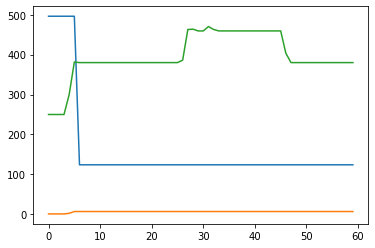

In [188]:
plt.plot(soc[10240:10300])
plt.plot(opid[10240:10300])
plt.plot(load[10240:10300])
#plt.plot(load[14420:14425])

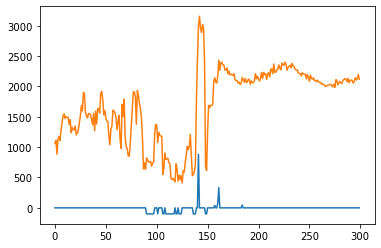

In [164]:
plt.plot(bat[18200:18500])
#plt.plot(dg0[5000:15000])
#plt.plot(dg1[5000:15000])
plt.plot(load[18200:18500])

In [124]:
fc = (0.238*dg0)/720 + (0.238*dg1)/720
sum_fc = sum(fc)
sum_fc

38234.078124619555

In [216]:
df6 = df3.copy()

load = df6['Load'].values
dg0 = df6['engMdoPower_0_'].values
dg1 = df6['engMdoPower_1_'].values
dg2 = df6['engMdoPower_2_'].values
dg3 = df6['engMdoPower_3_'].values
bat = df6['Battery'].values
soc = [0]*120960
soc[0] = 124 #124 empty (20%) 496(80%)
opid = df6['operationId'].values

# DP mode, battery is used for spinning reserve 
for i in range(len(load)):
    if i == 120959:
        pass
    elif opid[i] == 100:
        if load[i] <= 2100 and load[i+1] <= 2100 and soc[i] >= 310:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100 and soc[i] >= 310:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
            
        elif load[i] <= 2100 and load[i+1] <= 2100 and soc[i] < 310:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100 and soc[i] < 310:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]            
            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]

#Transit mode
    elif opid[i] == 3 or opid[i] == 5:
#        if load[i] < 840 and soc[i] < 496:
#            bat[i] = -100
#            dg0[i] = load[i] - bat[i]
#            soc[i+1] = soc[i] - bat[i]/720 
        if load[i] <= 2100 and load[i+1] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]*1.08
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]*1.08
            soc[i+1] = soc[i] - bat[i]/720            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]           
        elif load[i] <= 4200 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 4200:
            dg0[i] = dg1[i] = 2100
            bat[i] = load[i] - dg0[i] - dg1[i]
            soc[i+1] = soc[i] - bat[i]/720
        
#Standby mode
    elif opid[i] == 7:
#        if load[i] < 840 and soc[i] < 496:
#            bat[i] = -100
#            dg0[i] = load[i] - bat[i]
#            soc[i+1] = soc[i] - bat[i]/720
#        elif load[i] < 840 and soc[i] >= 496:
#            dg0[i] = load[i]
#            soc[i+1] = soc[i]
        if load[i] <= 2100 and load[i+1] <= 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] <= 2100 and load[i+1] > 2100:
            dg0[i] = load[i]
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]*1.08
            soc[i+1] = soc[i] - bat[i]/720
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] > 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = 2100
            bat[i] = load[i] - dg0[i]*1.08
            soc[i+1] = soc[i] - bat[i]/720
            
        elif load[i] > 2100 and load[i-1] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 5 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 2100 and load[i-2] < 2100 and soc[i] <= 124: # if the load is over 2100 for less than 10 seconds battery covers
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]          
            
        elif load[i] <= 4200 and load[i-1] > 2100:
            dg0[i] = dg1[i] = load[i]/2
            soc[i+1] = soc[i]
        elif load[i] > 4200:
            dg0[i] = dg1[i] = 2100
            bat[i] = load[i] - dg0[i] - dg1[i]
            soc[i+1] = soc[i] - bat[i]/720
            
# port
    elif opid[i] == 1 and soc[i] < 496:
        bat[i] = -100
        dg0[i] = load[i] - bat[i]*1.08
        soc[i+1] = soc[i] - bat[i]/720
    elif opid[i] == 1 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i]    
    elif opid[i] == 6 and soc[i] < 496:
        bat[i] = -100
        dg0[i] = load[i] - bat[i]*1.08
        soc[i+1] = soc[i] - bat[i]/720
    elif opid[i] == 6 and soc[i] >= 496:
        dg0[i] = load[i]
        soc[i+1] = soc[i] 
    else:
        soc[i+1] = soc[i]

    

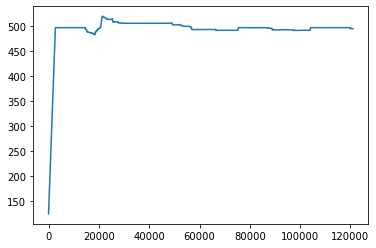

In [217]:
plt.plot(soc)#[10240:10300])
#plt.plot(opid[10240:10300])
#plt.plot(load[10240:10300])
#plt.plot(load[14420:14425])

In [218]:
fc = (0.238*dg0)/720 + (0.238*dg1)/720
sum_fc = sum(fc)
sum_fc

41110.13973135907

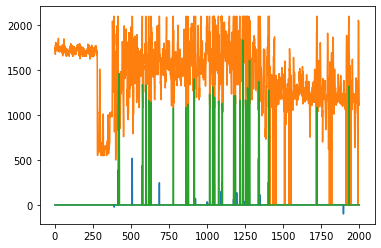

In [219]:
plt.plot(bat[14000:16000])
plt.plot(dg0[14000:16000])
plt.plot(dg1[14000:16000])
